### Neurala Nätverk är modeller för Allmän Linjär Regression 

<img src="../data/mlpnn.jpg">

$\hat{Y} = \varphi (\mathbf{XW} + \mathbf{b})$

att jämföra med

$\hat{Y} = \beta_0 + \beta_1X_1 …$

Varje $x_i w_{ij} + b_i$ är alltså en linje! Om aktiveringsfunktionen är linjär, så är hela systemet verkligen "bara" en multipel linjär regression.

Flera lager ger i princip en polynomiell regression, men viktigt är att inse att varje lager tar förra lagrets aktivering som input-- så det är djupa interaktionseffekter med avseende på featuremängden, som inte är enkla att skriva ner som polynom. Om det finns cykler eller genvägar i nätverket är det inte längre möjligt att skriva ner som ett polynom (det är då en iterativ serie, som kan vara kaotisk; jmf logistiska avbildningen $x_{n+1} = rx_n(1-x_n)$).

### Ickelinjäritet

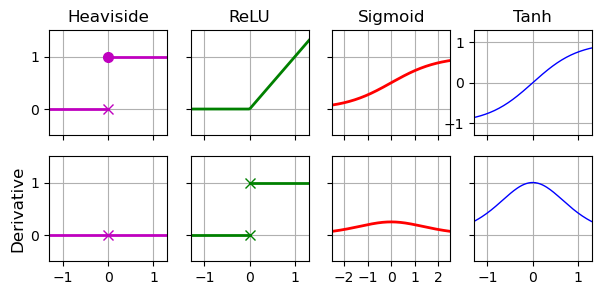

In [1]:
# activation functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

max_z = 2.5
z = np.linspace(-max_z, max_z, 200)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(7, 3))

axes[0, 0].plot([-max_z, 0], [0, 0], "m-", linewidth=2)
axes[0, 0].plot(0, 0, "mx", markersize=7)
axes[0, 0].plot(0, 1, "mo", markersize=7)
axes[0, 0].plot([0, max_z], [1, 1], "m-", linewidth=2)
axes[0, 0].set_title("Heaviside", fontsize=12)
axes[1, 0].plot(z, derivative(np.sign, z), "m-", linewidth=2)
axes[1, 0].plot(0, 0, "mx", markersize=7)
axes[1, 0].set_ylabel("Derivative", fontsize=12)

axes[0, 1].plot(z, relu(z), "g-", linewidth=2)
axes[0, 1].set_title("ReLU", fontsize=12)
axes[1, 1].plot([-max_z, 0], [0, 0], "g-", linewidth=2)
axes[1, 1].plot([0, max_z], [1, 1], "g-", linewidth=2)
axes[1, 1].plot(0, 0, "gx", markersize=7)
axes[1, 1].plot(0, 1, "gx", markersize=7)

axes[0, 2].plot(z, sigmoid(z), "r-", linewidth=2)
axes[0, 2].set_title("Sigmoid", fontsize=12)
axes[1, 2].plot(z, derivative(sigmoid, z), "r-", linewidth=2)

axes[0, 3].plot(z, np.tanh(z), "b-", linewidth=1)
axes[0, 3].set_title("Tanh", fontsize=12)
axes[1, 3].plot(z, derivative(np.tanh, z), "b-", linewidth=1)

for row in range(2):
    for col in range(4):
        axes[row, col].grid(True)
        if row == 0:
            axes[row, col].set_xticklabels([])
        if col == 2:
            axes[row, col].set_xlim(-max_z, max_z)
            axes[row, col].set_xticks([-2, -1, 0, 1, 2])
        else:
            axes[row, col].set_xlim(-1.3, 1.3)
            axes[row, col].set_xticks([-1, 0, 1])
        if col != 0 and ((row, col) != (0, 3)):
            axes[row, col].set_yticklabels([])
        if (row, col) == (0, 3):
            axes[row, col].set_ylim(-1.3, 1.3)
            axes[row, col].set_yticks([-1, 0, 1])
        else:
            axes[row, col].set_ylim(-0.5, 1.5)
            axes[row, col].set_yticks([0, 1])

plt.show()



Men vi löser inte detta system med statistisk anpassning. Inte minst kan vi inte hantera diskontinuerliga aktiveringsfunktioner med OLS eller MLE! Med numeriska närmevärden kommer vi undan detta, vilket är matematisk krångligt men praktiskt bekvämt.

Idéen är på ytan enkel, men matematiskt väldigt svårbegriplig! Se Appendix A i boken -- matematiken är mer än vi klarar med algebran vi lärt oss. Framör allt måste vi använda hyperkomplexa tal (_dualer_). För den hugade som inte är rädd för abstrakt algebra har Dr [Michael Penn](https://www.youtube.com/watch?v=ceaNqdHdqtg) en video om dem. Det finns andra enklare videor på youtube, men de begrepp som Dr Penn går igenom är det som faktiskt krävs för att kunna använda dem på egen hand.

I korta; dualer är en sorts tal som har "fler nollor" än vanliga tal. Specifikt finns en särskild symbol $\epsilon$ som har egenskapen $\epsilon^2 = 0$ (jämför med komplexa tal $i^2 = -1$).


Istället för att beräkna lutningen på alla linjerna separat, så uppskattar vi lutningarna (vikterna $w_{ij}$) för alla noder på en gång. Detta sker genom två pass genom nätverket: 
* I framåt riktningen beräknas alla noders värden (dvs $x_iw_{ij} + b_i$)
* I bakåt riktningen beräknas de partiella derivatorna för hela det multipla linjära systemet genom en hyperkomplex beräkningsgraf

Detta kallas <em>reverse-mode auto-diff</em>.

Nästa steg för att få en fungerande algoritm för att träna ett NN är att utföra <em>gradient descent</em>, dvs: 
* Justera vikterna $w_{ij}$ ett litet steg i den beräknade gradientens riktning. 

Upprepa!

När vi når något stopp-villkor så är vi klara. Detta kallas 'backpropagation'.

Notera att inget sades om vilken <em>sorts</em> gradient descent som används. I praktiken är <em>mini-batch gradient descent</em> det som är effektivast att köra på GPUer, men särskilt på CPU kan en sann stokastisk gradient descent (där vi alltså sätter någon sannolikhet för varje nod att vara med eller inte) vara lämplig. Detta är mindre sannolikt idag, eftersom även CPUer är väldigt parallella med dussintals, eller till och med hundratals, processorkärnor. 


Modern hårdvara är riktigt snabb, både CPU och GPU. På en AMD 7800X3D/7900GRE (en speldator som är en generation gammal och i näst högsta klassen av den generationens hårdvara) så är prestandan 8x högre för CPU och 4x snabbare för GPU än en gratisinstans på Colab (nVidia T4).

In [2]:
import torch
device = "cuda"

In [3]:
M = torch.rand((1000,1000))
M @ M.T # uppvärming; låter X3D cachen på CPU fyllas
%timeit M @ M.T

M = M.to(device)
M @ M.T # låter GDDR-cache på GPU fyllas
%timeit M @ M.T

2.87 ms ± 230 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
144 μs ± 10 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Att jämföra med Colab (nVidia T4): <br />
16.1 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)<br /> 
549 µs ± 3.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Och en Intel Core Ultra 7 265K / nVidia RTX 4000 Ada: <br />
1.64 ms ± 771 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)<br />
222 μs ± 236 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

7900GRE visar sig i detta enkla test var mycket snabbare än en T4 (och halva priset) och även snabbare än ett RTX 4000 Ada (men en tredjedel av priset). 

Sklearn har enklare neurala nätverk, men de är ganska begränsade. Däremot är de väldigt optimerade och förkompilerade, så de prestrerar ofta bra. Låt oss undersöka dem först, och sedan börja implementera samma sak fast med pytorch. 

In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target)

In [6]:
housing.feature_names, housing.target_names

(['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 ['MedHouseVal'])

In [7]:
# in och ut dimensioner räknas ut automatiskt! ReLU mellan dolda lager, linjärt ut och in
# early stopping för att undvika overfit
mlp_reg = MLPRegressor(hidden_layer_sizes=[50,50,50], early_stopping=True, verbose=True)

In [8]:
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)

Iteration 1, loss = 0.60918437
Validation score: 0.576903
Iteration 2, loss = 0.25431079
Validation score: 0.631478
Iteration 3, loss = 0.22092618
Validation score: 0.664192
Iteration 4, loss = 0.20076487
Validation score: 0.687444
Iteration 5, loss = 0.19086388
Validation score: 0.698790
Iteration 6, loss = 0.18243260
Validation score: 0.707403
Iteration 7, loss = 0.17824444
Validation score: 0.711576
Iteration 8, loss = 0.17181103
Validation score: 0.719807
Iteration 9, loss = 0.16311186
Validation score: 0.730915
Iteration 10, loss = 0.16124810
Validation score: 0.731667
Iteration 11, loss = 0.15709852
Validation score: 0.737978
Iteration 12, loss = 0.15387602
Validation score: 0.742696
Iteration 13, loss = 0.15154934
Validation score: 0.746699
Iteration 14, loss = 0.15034126
Validation score: 0.744200
Iteration 15, loss = 0.15502965
Validation score: 0.748330
Iteration 16, loss = 0.14685269
Validation score: 0.746659
Iteration 17, loss = 0.14562856
Validation score: 0.740382
Iterat

,steps,"[('standardscaler', ...), ('mlpregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,hidden_layer_sizes,"[50, 50, ...]"
,activation,'relu'
,solver,'adam'


In [9]:
mlp_reg.best_validation_score_

0.7733740558144517

In [10]:
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)

In [11]:
rmse

0.5294798115303009

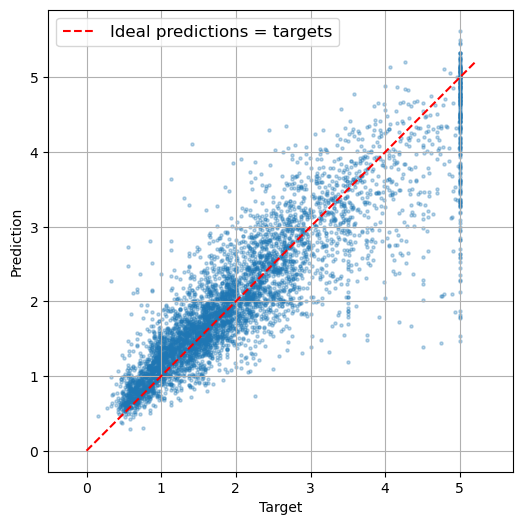

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=5, alpha=0.3)
plt.plot([0, 5.2], [0,5.2], color='red', linestyle='--', label="Ideal predictions = targets")
plt.axis("equal")
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.legend(fontsize=12)
plt.grid()
plt.show()

### Backpropagation i Torch

#### Autograd, reverse-mode autodiff i pytorch



$f(x) = x^2$

$f(5) = 25$

$f'(x) = 2x$

$f'(5) = 10$

In [13]:
x = torch.tensor(5.0, requires_grad=True)
f = x ** 2
f

tensor(25., grad_fn=<PowBackward0>)

In [14]:
f.backward() # reverse-mode auto-diff
x.grad # f och x är kopplade tack vare requires_grad!

tensor(10.)

#### Backpropagation

In [15]:
learning_rate = 0.1 # hur stort steg vi tar
x = torch.tensor(5.0, requires_grad=True)
for iteration in range(100):
    f = x**2 # framåt passet, beräkna alla värden
    f.backward() # bakåtpasset genom beräkningsgrafen
    # gradient descent
    with torch.no_grad(): # koppla inte till gradienterna! vi vill räkna om dem senare
        x -= learning_rate * x.grad
    x.grad.zero_() # sätt gradienterna till 0 så vi räknar om från början



In [16]:
x # går mot 0, eftersom x^2 har sitt minimum där!

tensor(1.0185e-09, requires_grad=True)

### Linjär regression med pytorch

In [17]:
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target)
print(f"Training set: {X_train.shape, y_train.shape}\nTest set: {X_test.shape, y_test.shape}")

Training set: ((15480, 8), (15480,))
Test set: ((5160, 8), (5160,))


In [18]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
means = X_train.mean(dim = 0, keepdim=True)
stds = X_train.std(dim=0, keepdims=True)
X_train = (X_train - means) / stds
X_test = (X_test - means) / stds

In [19]:
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)


In [20]:
n_features = X_train.shape[1]
w = torch.randn((n_features, 1), requires_grad=True) # initialisera med slumpässiga vikter
b = torch.tensor(0., requires_grad=True)


##### Batch Gradient Descent

In [21]:
learning_rate = 0.1
n_epochs = 100
for epoch in range(n_epochs):
    y_pred = X_train @ w + b
    loss = ((y_pred - y_train)**2).mean() # MSE
    loss.backward()
    with torch.no_grad():
        b -= learning_rate * b.grad
        w -= learning_rate * w.grad
        b.grad.zero_()
        w.grad.zero_()
    print(f"Epoch {epoch +1}/{n_epochs}, Loss: {loss.item()}")


Epoch 1/100, Loss: 23.89929962158203
Epoch 2/100, Loss: 12.077176094055176
Epoch 3/100, Loss: 6.742818832397461
Epoch 4/100, Loss: 4.1273193359375
Epoch 5/100, Loss: 2.7358531951904297
Epoch 6/100, Loss: 1.9421077966690063
Epoch 7/100, Loss: 1.4644794464111328
Epoch 8/100, Loss: 1.165845513343811
Epoch 9/100, Loss: 0.9739967584609985
Epoch 10/100, Loss: 0.8482762575149536
Epoch 11/100, Loss: 0.7645868062973022
Epoch 12/100, Loss: 0.7081140279769897
Epoch 13/100, Loss: 0.6695145964622498
Epoch 14/100, Loss: 0.6427890062332153
Epoch 15/100, Loss: 0.6240322589874268
Epoch 16/100, Loss: 0.610675036907196
Epoch 17/100, Loss: 0.6010102033615112
Epoch 18/100, Loss: 0.5938937664031982
Epoch 19/100, Loss: 0.5885526537895203
Epoch 20/100, Loss: 0.5844594836235046
Epoch 21/100, Loss: 0.5812522172927856
Epoch 22/100, Loss: 0.578679621219635
Epoch 23/100, Loss: 0.5765665173530579
Epoch 24/100, Loss: 0.5747892260551453
Epoch 25/100, Loss: 0.5732603073120117
Epoch 26/100, Loss: 0.5719168782234192
Epo

In [22]:
with torch.no_grad():
    y_pred = X_test @ w + b
    

In [23]:
root_mean_squared_error(y_test, y_pred)

0.7255085706710815

#### Direkt med pytorch

In [24]:
import torch.nn as nn
model = nn.Linear(in_features=n_features, out_features=1)


In [25]:
model.bias

Parameter containing:
tensor([0.3370], requires_grad=True)

In [26]:
model.weight

Parameter containing:
tensor([[-0.0443,  0.0425, -0.1187, -0.2506,  0.0673,  0.2358, -0.3358, -0.3361]],
       requires_grad=True)

In [27]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0443,  0.0425, -0.1187, -0.2506,  0.0673,  0.2358, -0.3358, -0.3361]],
       requires_grad=True)
Parameter containing:
tensor([0.3370], requires_grad=True)


In [28]:
model(X_train[:2])

tensor([[0.4153],
        [0.3318]], grad_fn=<AddmmBackward0>)

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

mse = nn.MSELoss()

In [30]:
def train_bgd(model, optimizer, criterion, X_train, y_train, n_epochs):
    for epoch in range(n_epochs):
        y_pred = model(X_train) # hela träningssettet, alltså Batch Gradient Descent
        loss = criterion(y_pred, y_train) # optimeringsvillkor, kostnadsfunktion, loss function
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")


In [31]:
train_bgd(model, optimizer, mse, X_train, y_train, n_epochs)

Epoch 1/100, Loss: 4.532883644104004
Epoch 2/100, Loss: 3.034252166748047
Epoch 3/100, Loss: 2.1295976638793945
Epoch 4/100, Loss: 1.5705516338348389
Epoch 5/100, Loss: 1.2196273803710938
Epoch 6/100, Loss: 0.9969653487205505
Epoch 7/100, Loss: 0.8545453548431396
Epoch 8/100, Loss: 0.7628111243247986
Epoch 9/100, Loss: 0.7032941579818726
Epoch 10/100, Loss: 0.6643437147140503
Epoch 11/100, Loss: 0.6385656595230103
Epoch 12/100, Loss: 0.6212486624717712
Epoch 13/100, Loss: 0.6093834042549133
Epoch 14/100, Loss: 0.6010430455207825
Epoch 15/100, Loss: 0.5949927568435669
Epoch 16/100, Loss: 0.5904395580291748
Epoch 17/100, Loss: 0.5868731737136841
Epoch 18/100, Loss: 0.5839651226997375
Epoch 19/100, Loss: 0.5815028548240662
Epoch 20/100, Loss: 0.5793489217758179
Epoch 21/100, Loss: 0.5774139165878296
Epoch 22/100, Loss: 0.5756391286849976
Epoch 23/100, Loss: 0.5739861726760864
Epoch 24/100, Loss: 0.572429358959198
Epoch 25/100, Loss: 0.5709512829780579
Epoch 26/100, Loss: 0.569540441036224

In [32]:
with torch.no_grad():
    y_pred = model(X_test)
root_mean_squared_error(y_test, y_pred)

0.7133355140686035

In [33]:
model = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=50),nn.ReLU(),
    nn.Linear(50, 50), nn.ReLU(),
    nn.Linear(50, 50), nn.ReLU(),
    nn.Linear(50, 50), nn.ReLU(),
    nn.Linear(50, 1))

optimizer = torch.optim.Adam(model.parameters())
train_bgd(model, optimizer, mse, X_train, y_train, n_epochs*10)
with torch.no_grad():
    y_pred = model(X_test)


Epoch 1/1000, Loss: 5.440515041351318
Epoch 2/1000, Loss: 5.381772994995117
Epoch 3/1000, Loss: 5.324398040771484
Epoch 4/1000, Loss: 5.2676215171813965
Epoch 5/1000, Loss: 5.210504055023193
Epoch 6/1000, Loss: 5.152128219604492
Epoch 7/1000, Loss: 5.091976642608643
Epoch 8/1000, Loss: 5.029674530029297
Epoch 9/1000, Loss: 4.964518070220947
Epoch 10/1000, Loss: 4.8957133293151855
Epoch 11/1000, Loss: 4.822622776031494
Epoch 12/1000, Loss: 4.744919300079346
Epoch 13/1000, Loss: 4.662341594696045
Epoch 14/1000, Loss: 4.574480056762695
Epoch 15/1000, Loss: 4.480437755584717
Epoch 16/1000, Loss: 4.377966403961182
Epoch 17/1000, Loss: 4.26515007019043
Epoch 18/1000, Loss: 4.14070463180542
Epoch 19/1000, Loss: 4.00322961807251
Epoch 20/1000, Loss: 3.851566791534424
Epoch 21/1000, Loss: 3.685009479522705
Epoch 22/1000, Loss: 3.503671169281006
Epoch 23/1000, Loss: 3.308689594268799
Epoch 24/1000, Loss: 3.1019997596740723
Epoch 25/1000, Loss: 2.886223316192627
Epoch 26/1000, Loss: 2.66457962989

In [34]:
root_mean_squared_error(y_test, y_pred)


0.5317755937576294

In [35]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, 
                          pin_memory=True, num_workers=16, persistent_workers=True)

In [36]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(n_features, 50),
    nn.ReLU(),
    nn.Linear(50, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)
device = "cuda"
model.to(device, non_blocking=True)

Sequential(
  (0): Linear(in_features=8, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=1, bias=True)
)

In [37]:
def train(model, optimizer, criterion, train_loader, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        total_loss = 0.
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device, non_blocking=True),y_batch.to(device, non_blocking=True)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        mean_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch +1} / {n_epochs}, Loss: {mean_loss:.4f}")

In [38]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
mse = nn.MSELoss()

In [39]:
n_epochs = 20
train(model, optimizer, mse, train_loader, n_epochs)

Epoch 1 / 20, Loss: 0.6029
Epoch 2 / 20, Loss: 0.4445
Epoch 3 / 20, Loss: 0.4173
Epoch 4 / 20, Loss: 0.3966
Epoch 5 / 20, Loss: 0.3820
Epoch 6 / 20, Loss: 0.3685
Epoch 7 / 20, Loss: 0.3576
Epoch 8 / 20, Loss: 0.3491
Epoch 9 / 20, Loss: 0.3396
Epoch 10 / 20, Loss: 0.3346
Epoch 11 / 20, Loss: 0.3294
Epoch 12 / 20, Loss: 0.3243
Epoch 13 / 20, Loss: 0.3212
Epoch 14 / 20, Loss: 0.3190
Epoch 15 / 20, Loss: 0.3154
Epoch 16 / 20, Loss: 0.3122
Epoch 17 / 20, Loss: 0.3043
Epoch 18 / 20, Loss: 0.3075
Epoch 19 / 20, Loss: 0.3022
Epoch 20 / 20, Loss: 0.2988


### Klassificering

In [40]:
from sklearn.datasets import fetch_openml

fashion_mnist = fetch_openml(name="fashion-mnist", as_frame=False, parser="liac-arff")
targets = fashion_mnist.target.astype(int)


In [41]:
X_train, y_train = fashion_mnist.data[:60_000], targets[:60_000]
X_test , y_test = fashion_mnist.data[60000:], targets[60000:]

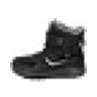

In [42]:
X_sample = X_train[0].reshape(28,28)
plt.figure(figsize=(1,1))
plt.imshow(X_sample, cmap="binary")
plt.axis('off')
plt.show()

In [43]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [44]:
class_names[y_train[0]]

'Ankle boot'

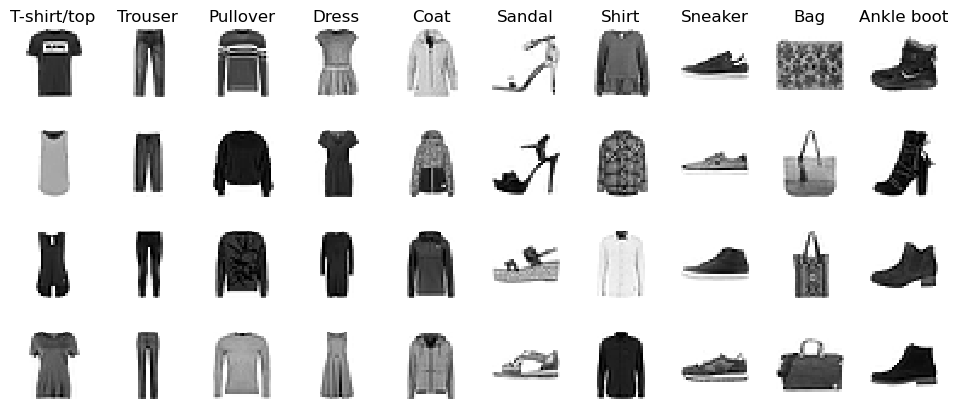

In [45]:
n_rows = 4
plt.figure(figsize=(12, n_rows*1.2))
for row in range(n_rows):
    for class_index in range(10):
        X_img = X_train[y_train==class_index][row].reshape(28, 28)
        y_img = y_train[y_train==class_index][row]
        plt.subplot(n_rows, 10, 10 *row + class_index + 1)
        plt.imshow(X_img, cmap="binary", interpolation="nearest")
        plt.axis('off')
        if row == 0:
            plt.title(class_names[y_img])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [46]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

mlp_clf = MLPClassifier(hidden_layer_sizes=[200, 200], early_stopping=True, verbose=True)
pipeline = make_pipeline(MinMaxScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)

Iteration 1, loss = 0.55142342
Validation score: 0.838167
Iteration 2, loss = 0.38711462
Validation score: 0.869167
Iteration 3, loss = 0.34393531
Validation score: 0.878000
Iteration 4, loss = 0.31766744
Validation score: 0.876500
Iteration 5, loss = 0.29952927
Validation score: 0.882000
Iteration 6, loss = 0.28173049
Validation score: 0.890000
Iteration 7, loss = 0.26971608
Validation score: 0.873000
Iteration 8, loss = 0.25661978
Validation score: 0.892167
Iteration 9, loss = 0.24514345
Validation score: 0.894000
Iteration 10, loss = 0.23472198
Validation score: 0.891167
Iteration 11, loss = 0.22409616
Validation score: 0.889333
Iteration 12, loss = 0.21862032
Validation score: 0.891333
Iteration 13, loss = 0.20932700
Validation score: 0.891000
Iteration 14, loss = 0.20328598
Validation score: 0.895667
Iteration 15, loss = 0.19355356
Validation score: 0.898000
Iteration 16, loss = 0.19136474
Validation score: 0.890833
Iteration 17, loss = 0.18266114
Validation score: 0.903167
Iterat

In [47]:
accuracy

0.8946

In [48]:
mlp_clf.best_validation_score_

0.9031666666666667

In [49]:
y_hat = pipeline.predict(X_test)

In [50]:
y_test

array([9, 2, 1, ..., 8, 1, 5], shape=(10000,))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.83      0.80      0.81      1000
           3       0.89      0.91      0.90      1000
           4       0.79      0.83      0.81      1000
           5       0.97      0.96      0.97      1000
           6       0.75      0.71      0.73      1000
           7       0.94      0.96      0.95      1000
           8       0.98      0.97      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



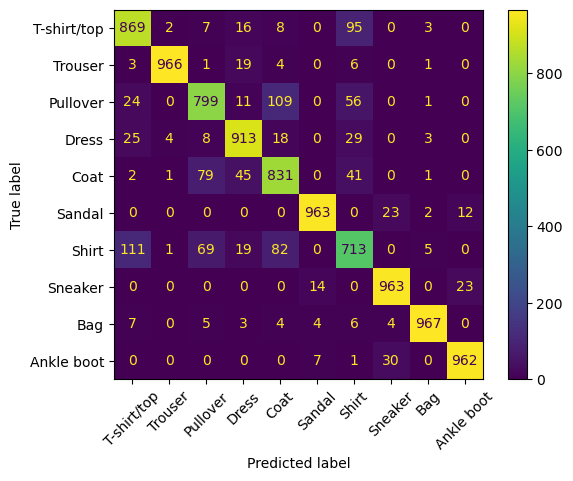

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_hat)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(xticks_rotation=45)
print(classification_report(y_test, y_hat))